Assignments:

To close out this checkpoint, you'll do two assignments. Both require you to create Jupyter notebooks. Please submit links to your notebooks below

1.Predicting temperature:

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of this dataset from Kaggle. To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

First, load the dataset from the weatherinszeged table from Thinkful's database.
Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.
Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.
Here are the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'
As in earlier assignments, be sure to close the database connection after initially pulling in your data.

In [1]:
# Import some libraries and packages:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings(action="ignore")
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Connect to dataset:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format( postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from weatherinszeged', con = engine)
engine.dispose()

In [3]:
# Look at the data set:
df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.47,7.39,0.89,14.12,251.00,15.83,0.00,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.36,7.23,0.86,14.26,259.00,15.83,0.00,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.38,9.38,0.89,3.93,204.00,14.96,0.00,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.29,5.94,0.83,14.10,269.00,15.83,0.00,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.76,6.98,0.83,11.04,259.00,15.83,0.00,1016.51,Partly cloudy throughout the day.


In [4]:
# Look at the data type and non-null columns:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [5]:
df.shape

(96453, 12)

In [6]:
# Build a regression model:
# Y is the target variable:
Y = df['temperature']
# X is the feature set which includes humidity, windspeed, windbearing, and pressure:
X = df[['humidity', 'windspeed', 'windbearing', 'pressure']]
# We need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Wed, 15 Jan 2020   Prob (F-statistic):               0.00
Time:                        22:54:47   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now, check if the model meets the Gauss-Markov Conditions:
    
1.Assumption one: linearity of the model in its coefficients:
The first assumption that must be met is that the target variable should be a linear function of the model's coefficients.
The relationship could be quadratic or higher order. A model like 𝑦=𝛽0+𝛽1𝑥1+𝛽2𝑥2^2+𝜖 is completely valid:
So,modeling the temperature with linear regression is:

temperature = 37.9264 - 32.4962 humidity - 0.2014 windspeed + 0.0040 windbearing - 0.0007 pressure	

So use scatterplot to check for linearity: 

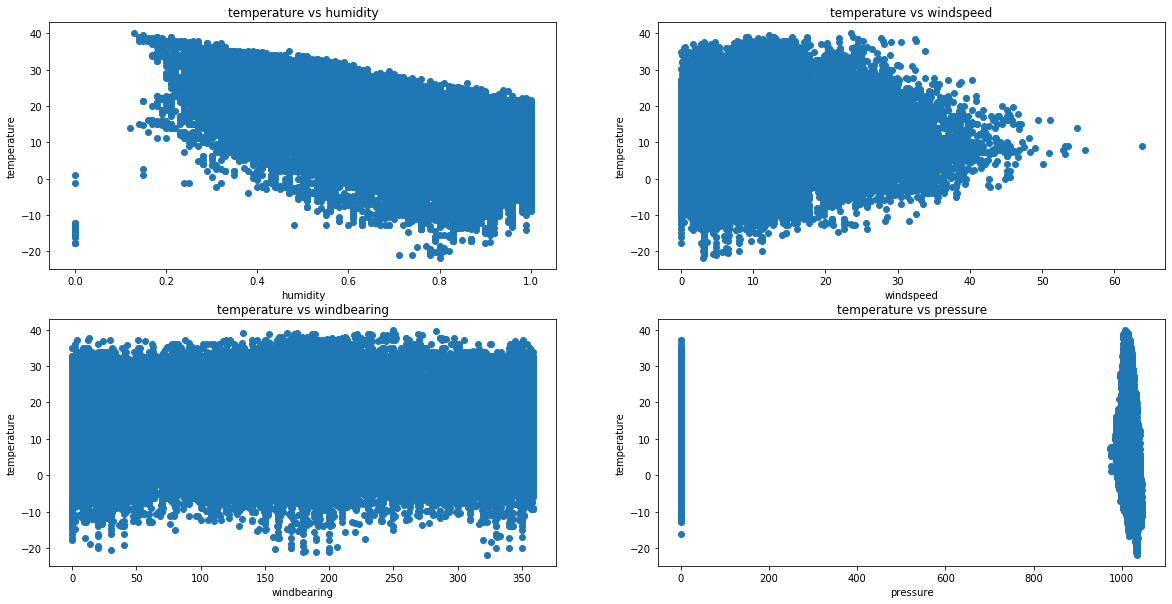

In [7]:
# Look at the distribution of target variable with two variables with weak correlation:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.scatter(df['humidity'], df['temperature'])
plt.xlabel('humidity')
plt.ylabel('temperature')
plt.title('temperature vs humidity')

plt.subplot(2,2,2)
plt.scatter(df['windspeed'], df['temperature'])
plt.xlabel('windspeed')
plt.ylabel('temperature')
plt.title('temperature vs windspeed')

plt.subplot(2,2,3)
plt.scatter(df['windbearing'], df['temperature'])
plt.xlabel('windbearing')
plt.ylabel('temperature')
plt.title('temperature vs windbearing')

plt.subplot(2,2,4)
plt.scatter(df['pressure'], df['temperature'])
plt.xlabel('pressure')
plt.ylabel('temperature')
plt.title('temperature vs pressure')

plt.show()

As you can see here, the target variable has a linear function of the model's coeficients.???? correct???

2.Assumption two: the error term should be zero on average:
The error term accounts for the variation in the target variable that is not explained by the features. As long as we include a constant in a model, we shouldn't be worried about this assumption as the constant will force the error terms to be zero on average.

In [8]:
# To see mean of the errors in the temperature model:
predictions = results.predict(X)
errors = Y - predictions

print("Mean of the errors in the temperature model is: {}".format(np.mean(errors)))

Mean of the errors in the temperature model is: 9.967115112774813e-12


Since, we include the constant term in the model, the average of the model's error is effectively zero.

3.Assumption three: homoscedasticity:A model is homoscedastic when the error variance shouldn't systematically change across observations.
When this assumption is not met, we are dealing with heteroscedasticity.
Thankfully, there are several formal statistical tests that we can use to determine whether there is heteroscedasticity in the error terms. Here, we demonstrate two of them: Bartlett and Levene tests. The null hypothesis for both tests is that the errors are homoscedastic.

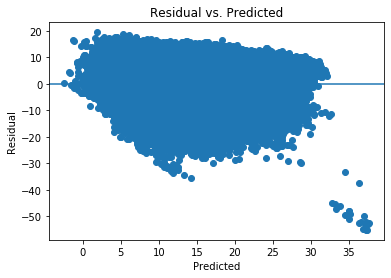

In [9]:
# First, let's checkout whether temperature model suffers from heteroscedasticity by visualizing it:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

It seems that error variance is higher for the higher values of the target variable. This implies that our error terms aren't homoscedastic.

In [10]:
# Now check with statistical test:
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


The p-values of both tests are 0. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

Some fixes to heteroscedasticity include transforming the dependent variable by boxcox transformation or log transformations and adding features that target the poorly-estimated areas.
But Box-Cox and log transformations only work when all datapoints are positive.
so the only way is adding features that target the poorly-estimated areas.

4.Assumption four: low multicollinearity:
Individual features should be only weakly correlated with one another, and ideally completely uncorrelated.
To detect multicollinearity, we can simply look at the correlation matrix of the features.

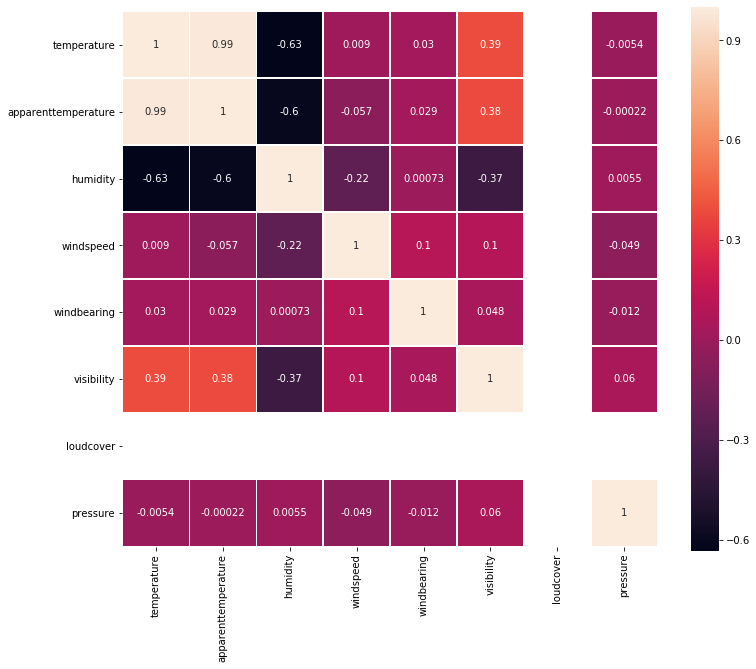

In [11]:
# Using heatmap plot to look at the correlation matrix of the features.
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), square=True, annot=True, linewidths=.2)

As you can see features have very low correlation with each other. Also, only humidity has a highest absolute correlation with target variable(temperature).????correct??

Also, if there is correlation of 1 or -1 between a variable and another or several variables, this is called perfect multicollinearity.  

Multicollinearity can be fixed by PCA or by discarding some of the correlated features. I think humidity with -0.63 can make multicollinearity. So, by removing humidity feature from model or using PCA, we can make a low multicollinearity.

5.Assumption five: error terms should be uncorrelated with one another:

Error terms should be uncorrelated with one another. In other words, the error term for one observation shouldn't predict the error term for another.
To identify whether the error terms are correlated with each other or not, we can graph them. In the graph, we need to observe randomness.

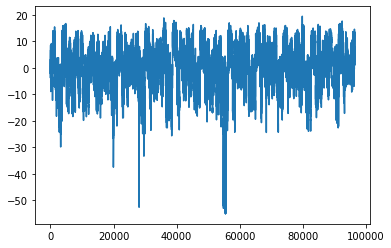

In [12]:
# Check error terms are correlated with each other or not:
plt.plot(errors)
plt.show()

It seems that the error terms of our model are uncorrelated with each other.

Another way to look at correlations between errors is to use the autocorrelation function. This function computes the correlation of a variable with itself. 

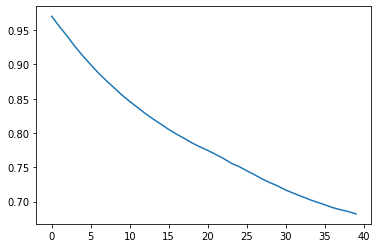

In [13]:
# Look at correlations between errors by using the autocorrelation function:
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

So, the autocorrelation between the errors of our temperature model is indeed very low (ranging between 0.70 and 0.95)
???correct??? which range would be high?

6.Assumption six: features shouldn't be correlated with the errors:
Explanatory variables and errors should be independent. If this assumption doesn't hold, then the model's predictions will be unreliable as the estimates of the coefficients would be biased. This assumption is known as the exogeneity.

Common causes are omitted variables and simultaneous causation between independent variables and the target.

???? I dont know how to check this assumption???????

Another important thing to consider is the normality of the error terms. In order to measure the statistical significance of our estimated coefficients, error terms must be normally distributed.

More often than not, non-normally distributed errors stem from omitted variables. Including the omitted relevant features to the model may help fix the issue. Sometimes, transforming the dependent variable also helps.

There are various ways to check for normality of error terms. An informal way of doing this is by visualizing the errors in a QQ plot or to look at the histogram:

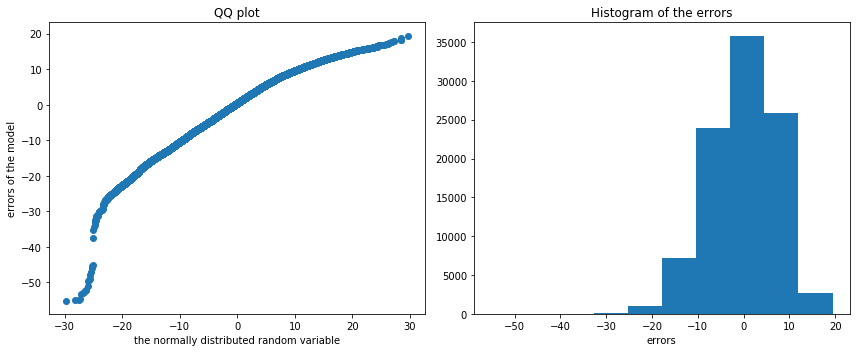

In [14]:
# Look at the QQ plot andhistogram to visualize errors distribution:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

As can be seen in the charts above, our errors are not normally distributed exactly. But the QQ plot and the histogram imply that the distribution is not very far away from normal.

We apply formal statistical tests: Jarque Bera and normal tests. 

The null hypothesis of both tests is that the errors are normally distributed.

In [15]:
# Now check with statistical test:

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.2967352522674 and p value is 0.0
Normality test statistics is 3375.4323076995142 and p value is 0.0


The p-values of both tests indicate that our errors are not normally distributed.